# Exercice 9: Transformations, CRS, buffers, affichage et export
O. Kaufmann, 2020, 2023, 2025.

In [1]:

# @info: Execute me to activate interactive questions
# ---------------------------------------------------

# O. KAUFMANN, 2024. 

from IPython import get_ipython
from IPython.core import magic_arguments
from IPython.core.magic import register_cell_magic
import ipywidgets as widgets
from IPython.display import HTML, clear_output
import codecs

def decode_text(text):
    return codecs.decode(text, 'hex').decode('utf')

def encode_text(text):
    return codecs.encode(codecs.encode(text,'utf8'), 'hex').decode('utf')
    
@magic_arguments.magic_arguments()
@magic_arguments.argument('--prompt', default='none', help='Encoded prompt')
@magic_arguments.argument('--answer', default='none', help='Encoded answer')
@magic_arguments.argument('--title', default='Question', help='First line of alert block')
@magic_arguments.argument('--button-label', default='Solution', help='Text to display on button')
@magic_arguments.argument('--div-type', default='alert-warning', help='Type of alert block')
    
@register_cell_magic
def display_prompt(line, cell):
    args = magic_arguments.parse_argstring(display_prompt, line)
    title = args.title
    prompt = args.prompt
    answer = args.answer
    button_label = args.button_label
    div_type = args.div_type
    def make_block(text, title=title, label=button_label, div_type=div_type):
        if title != 'none':
            return HTML(f"""<div class="alert alert-block {div_type}"> <b>{title}</b><br> {text} </div>""")
        else:
            return HTML(f"""<div class="alert alert-block {div_type}"> {text} </div>""")
    if prompt != 'none':
        display(make_block(decode_text(prompt)))
    toggle_button = widgets.ToggleButton(description=button_label)
    output = widgets.Output()
    def on_button_clicked(b):
        with output:
            if b['new']:  
                display(HTML(decode_text(answer)))
            else:
                output.clear_output()
    toggle_button.observe(on_button_clicked, 'value')
    display(toggle_button)
    display(output)

HTML("""<div class="alert alert-block alert-success"> <b>Success:</b><br>Interactive questions activated.</div>""")


Important: Exécutez-moi pour activer les questions interactives.

***
## 1. Imports

<div class="alert alert-block alert-info">
<b>Info:</b><br>     <b>pyproj :</b> pour gérer les projections et transformations entre projections  <br>
    <b>fiona :</b> pour lire et écrire des géodonnées aux formats standards  <br>
    <b>descartes :</b> pour afficher des objets shapely ou GeoJSON avec matplotlib
</div>

In [2]:
import matplotlib.pyplot as plt
import shapely
import fiona
from fiona.crs import from_epsg
import pyproj
from shapely.geometry import Point, LineString, MultiPoint, Polygon
from shapely.affinity import rotate, translate
from shapely.ops import transform
from descartes.patch import PolygonPatch
from collections import OrderedDict
import geopandas as gpd

***
## 2. Création des géométries

<div class="alert alert-block alert-info">
<b>Info:</b><br>     On a réalisé des relevés le long d'un profil passant par les trois repères A, B et C. Le profil démarre au point A, le point B se situe 100m au nord du point A et le point C à 150m du point B. L'azimuth de BC est de N50°E.<br>
    <br>
    Rem: On souhaite travailler dans le système de coordonnées Lambert Belge 1972, considère que les distances sont comptées dans le plan de la projection cartographique et que l'azimuth est compté par rapport au nord de la carte. Les segments entre les repères sont considérés rectilignes.
</div>

<div class="alert alert-block alert-warning">
<b>Question 2.0.1: </b><br>Créez un objet qui représentent les points de repères A, B et C.
</div>

<div class="alert alert-block alert-info">
<b>Info:</b><br>     Utilisez les fonctions translate et rotate.
</div>

In [3]:

%%display_prompt --title=none --prompt 536920766f757320c3aa74726520626c6f7175c3a92865292c20616666696368657a20756e6520736f6c7574696f6e20656e207072657373616e7420737572206c6520626f75746f6e2063692d646573736f7573 --answer 3c636f64653e41203d20506f696e7428302c2030293c62723e0a42203d20506f696e7428302c20313030293c62723e0a43203d20506f696e7428302c20313530293c62723e0a43203d20726f7461746528432c202d35302c206f726967696e3d41293c62723e0a43203d207472616e736c61746528432c20422e782c20422e79293c62723e0a432e78793c2f636f64653e
# @info: Exécutez-moi pour avoir accès aux interactions

# @info: Exécutez-moi pour avoir accès aux interactions


In [4]:

%%display_prompt --title=none --prompt 536920766f757320c3aa74726520626c6f7175c3a92865292c20616666696368657a20756e6520736f6c7574696f6e20656e207072657373616e7420737572206c6520626f75746f6e2063692d646573736f7573 --answer 3c636f64653e72657065726573203d204d756c7469506f696e742828412c422c4329293c62723e0a726570657265733c2f636f64653e
# @info: Exécutez-moi pour avoir accès aux interactions

# @info: Exécutez-moi pour avoir accès aux interactions


<div class="alert alert-block alert-warning">
<b>Question 2.0.2: </b><br>Créez un objet qui représente le profil et un objet qui représente les points de repères A, B et C.
</div>

In [5]:

%%display_prompt --title=none --prompt 536920766f757320c3aa74726520626c6f7175c3a92865292c20616666696368657a20756e6520736f6c7574696f6e20656e207072657373616e7420737572206c6520626f75746f6e2063692d646573736f7573 --answer 3c636f64653e70726f66696c203d204c696e65537472696e672828412c20422c204329293c62723e0a70726f66696c3c2f636f64653e
# @info: Exécutez-moi pour avoir accès aux interactions

# @info: Exécutez-moi pour avoir accès aux interactions


<div class="alert alert-block alert-success">
	<b>2.1 Créer les stations de mesures</b>
</div>

<div class="alert alert-block alert-info">
<b>Info:</b><br>     Les mesures ont été effectuées tous les 10m le long de ce profil en partant au point A et en allant jusqu'au point C compris.
</div>

<div class="alert alert-block alert-warning">
<b>Question 2.1.1: </b><br>Créez les stations de mesures et stockez-les dans un GeoDataFrame geopandas
</div>

<div class="alert alert-block alert-info">
<b>Info:</b><br>     Utilisez la méthode <i>from_features</i> pour créer le GeoDataFrame.
</div>

In [ ]:
# Résultat attendu ci-dessous...

[{'type': 'Feature',
  'properties': {'name': 'station_000', 'color': 'lightblue'},
  'geometry': <POINT (0 0)>},
 {'type': 'Feature',
  'properties': {'name': 'station_010', 'color': 'lightblue'},
  'geometry': <POINT (0 10)>},
 {'type': 'Feature',
  'properties': {'name': 'station_020', 'color': 'lightblue'},
  'geometry': <POINT (0 20)>},
 {'type': 'Feature',
  'properties': {'name': 'station_030', 'color': 'lightblue'},
  'geometry': <POINT (0 30)>},
 {'type': 'Feature',
  'properties': {'name': 'station_040', 'color': 'lightblue'},
  'geometry': <POINT (0 40)>},
 {'type': 'Feature',
  'properties': {'name': 'station_050', 'color': 'lightblue'},
  'geometry': <POINT (0 50)>},
 {'type': 'Feature',
  'properties': {'name': 'station_060', 'color': 'lightblue'},
  'geometry': <POINT (0 60)>},
 {'type': 'Feature',
  'properties': {'name': 'station_070', 'color': 'lightblue'},
  'geometry': <POINT (0 70)>},
 {'type': 'Feature',
  'properties': {'name': 'station_080', 'color': 'lightblue'

In [70]:
features = stations_de_mesure.copy()

In [71]:
features.append({'type': 'Feature', 'properties': {'name': f'profil',  'color': 'lightgreen'}, 'geometry' : profil})
features.append({'type': 'Feature', 'properties': {'name': f'reperes', 'color': 'violet'}, 'geometry' : reperes})

In [72]:
feature_coll = {
    "type": "FeatureCollection",
    "features": features}

<Axes: >

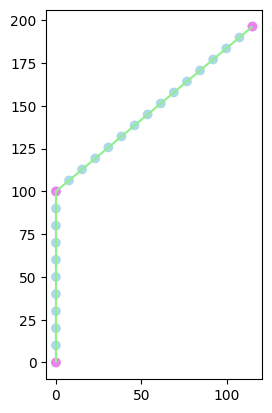

In [73]:
gdf = gpd.GeoDataFrame.from_features(feature_coll)
gdf.plot(color=gdf.color)

***
## 3. Appliquer des transformations 

<div class="alert alert-block alert-info">
<b>Info:</b><br>     On souhaite obtenir des géométries dans le système Lambert Belge 1972 en prenant en compte des informations suivantes:   <br>
    Le point B a fait l'objet d'un relevé au DGPS. Ses coordonnées dans le système WGS84 sont (4.890424E, 50.184786N).  
</div>

<div class="alert alert-block alert-warning">
<b>Question 3.0.1: </b><br>Créez le point B.
</div>

<div class="alert alert-block alert-warning">
<b>Question 3.0.2: </b><br>Utilisez pyproj pour définir les systèmes de coordonnées dans lesquels les différentes coordonnées seront exprimées.
</div>

In [42]:

%%display_prompt --title=none --prompt 536920766f757320c3aa74726520626c6f7175c3a92865292c20616666696368657a20756e6520736f6c7574696f6e20656e207072657373616e7420737572206c6520626f75746f6e2063692d646573736f7573 --answer 3c636f64653e7767733834203d20707970726f6a2e4352532827455053473a3433323627293c62723e0a6c623732203d20707970726f6a2e4352532827455053473a333133373027293c2f636f64653e
# @info: Exécutez-moi pour avoir accès aux interactions

# @info: Exécutez-moi pour avoir accès aux interactions


<div class="alert alert-block alert-warning">
<b>Question 3.0.3: </b><br>Définissez la transformation entre les systèmes de coordonnées WGS84 et LB72 et créez un objet représentant le point de repère B dans le système LB72.
</div>

In [43]:

%%display_prompt --title=none --prompt 536920766f757320c3aa74726520626c6f7175c3a92865292c20616666696368657a20756e6520736f6c7574696f6e20656e207072657373616e7420737572206c6520626f75746f6e2063692d646573736f7573 --answer 3c636f64653e70726f6a656374203d20707970726f6a2e5472616e73666f726d65722e66726f6d5f6372732877677338342c206c6237322c20616c776179735f78793d54727565292e7472616e73666f726d3c62723e0a425f4c423732203d207472616e73666f726d2870726f6a6563742c20425f5747533834293c2f636f64653e
# @info: Exécutez-moi pour avoir accès aux interactions

# @info: Exécutez-moi pour avoir accès aux interactions


<div class="alert alert-block alert-warning">
<b>Question 3.0.4: </b><br>Calculez les composantes du vecteur translation à appliquer.
</div>

In [44]:

%%display_prompt --title=none --prompt 536920766f757320c3aa74726520626c6f7175c3a92865292c20616666696368657a20756e6520736f6c7574696f6e20656e207072657373616e7420737572206c6520626f75746f6e2063692d646573736f7573 --answer 3c636f64653e6478203d20425f4c4237322e78202d20422e783c62723e0a6479203d20425f4c4237322e79202d20422e793c2f636f64653e
# @info: Exécutez-moi pour avoir accès aux interactions

# @info: Exécutez-moi pour avoir accès aux interactions


<div class="alert alert-block alert-warning">
<b>Question 3.0.5: </b><br>Translatez le GeoDataFrame et affichez-le.
</div>

***
## 4. Créer des Buffers autour des géométries converties en Lambert72

<div class="alert alert-block alert-warning">
<b>Question 4.0.1: </b><br>Créez un buffer de 5m autour des repères. 
</div>

In [52]:

%%display_prompt --title=none --prompt 536920766f757320c3aa74726520626c6f7175c3a92865292c20616666696368657a20756e6520736f6c7574696f6e20656e207072657373616e7420737572206c6520626f75746f6e2063692d646573736f7573 --answer 3c636f64653e726570657265735f4c4237325f627566666572203d206764662e717565727928276e616d653d3d22726570657265732227292e62756666657228352e293c2f636f64653e
# @info: Exécutez-moi pour avoir accès aux interactions

# @info: Exécutez-moi pour avoir accès aux interactions


<div class="alert alert-block alert-warning">
<b>Question 4.0.2: </b><br>Créez un buffer de 2.5 m autour du profil et des stations de mesure. 
</div>

***
## 5. Afficher toutes les géométries simultanément

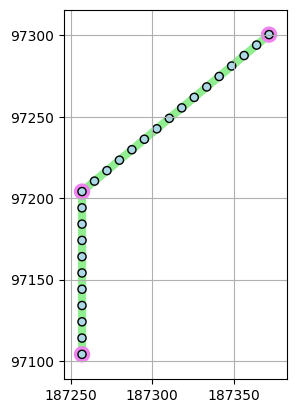

In [ ]:
# Résultat attendu ci-dessous...

***
## 6. Exporter les points

<div class="alert alert-block alert-warning">
<b>Question 6.0.1: </b><br><b>Exportez les points de repères et les stations de mesure.</b><br> Essayez les exports vers les formats shapefile, geojson et geopackage. 
</div>

<div class="alert alert-block alert-info">
<b>Info:</b><br>     Créez un nouveau GeoDataFrame où seront stockés chacun des repères et chacune des stations avec le nom et le type de point.
</div>

In [80]:

%%display_prompt --title=none --prompt 536920766f757320c3aa74726520626c6f7175c3a92865292c20616666696368657a20756e6520736f6c7574696f6e20656e207072657373616e7420737572206c6520626f75746f6e2063692d646573736f7573 --answer 3c636f64653e6665617475726573203d205b5d3c62723e0a666f72207320696e2073746174696f6e735f64655f6d65737572653a3c62723e0a20202020735b2770726f70657274696573275d5b2774797065275d3d2773746174696f6e27203c62723e0a2020202066656174757265732e617070656e642873293c62723e0a72657065726573203d207b277265706572655f41273a20412c20277265706572655f42273a20422c20277265706572655f43273a20437d3c62723e0a66656174757265732e657874656e64285b7b2770726f70657274696573273a7b276e616d65273a206b2c202774797065273a27726570657265272c2027636f6c6f72273a202776696f6c6574277d2c2767656f6d65747279273a20767d20666f72206b2c207620696e20726570657265732e6974656d7328295d293c62723e0a666561747572655f636f6c6c203d207b3c62723e0a202020202274797065223a202246656174757265436f6c6c656374696f6e222c3c62723e0a20202020226665617475726573223a2066656174757265737d3c62723e0a6764665f706f696e7473203d206770642e47656f446174614672616d652e66726f6d5f666561747572657328666561747572655f636f6c6c2c206372733d27657073673a333133373027293c62723e0a6764665f706f696e74735b2767656f6d65747279275d203d206764665f706f696e74732e7472616e736c6174652864782c6479293c62723e0a6764665f706f696e74732e706c6f7428636f6c6f723d6764665f706f696e74732e636f6c6f72293c2f636f64653e
# @info: Exécutez-moi pour avoir accès aux interactions

# @info: Exécutez-moi pour avoir accès aux interactions


<div class="alert alert-block alert-warning">
<b>Question 6.0.2: </b><br>Exportez les repères aux formats ESRI shapefile, geojson et geopackage...
</div>

In [88]:

%%display_prompt --title=none --prompt 536920766f757320c3aa74726520626c6f7175c3a92865292c20616666696368657a20756e6520736f6c7574696f6e20656e207072657373616e7420737572206c6520626f75746f6e2063692d646573736f7573 --answer 3c636f64653e6764665f72657065726573203d206764665f706f696e74732e71756572792827747970653d3d227265706572652227293c62723e0a6764665f726570657265732e746f5f66696c652827726570657265732e73687027293c62723e0a6764665f726570657265732e746f5f66696c652827726570657265732e67656f6a736f6e27293c62723e0a6764665f726570657265732e746f5f66696c652827726570657265732e67706b6727293c2f636f64653e
# @info: Exécutez-moi pour avoir accès aux interactions

# @info: Exécutez-moi pour avoir accès aux interactions
